In [41]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import utils
importlib.reload(utils)

<module 'utils' from '/home/maxi/Documents/entropia_de_la_informacion/utils.py'>

In [42]:
import data_loading
importlib.reload(data_loading)
df = data_loading.hilbert_dataframe_from_folder("data", crop_size=512)

print(df.shape)


(262144, 10)


# Ordinal patterns para m = 3, 4, 5 y tau = 1, 2

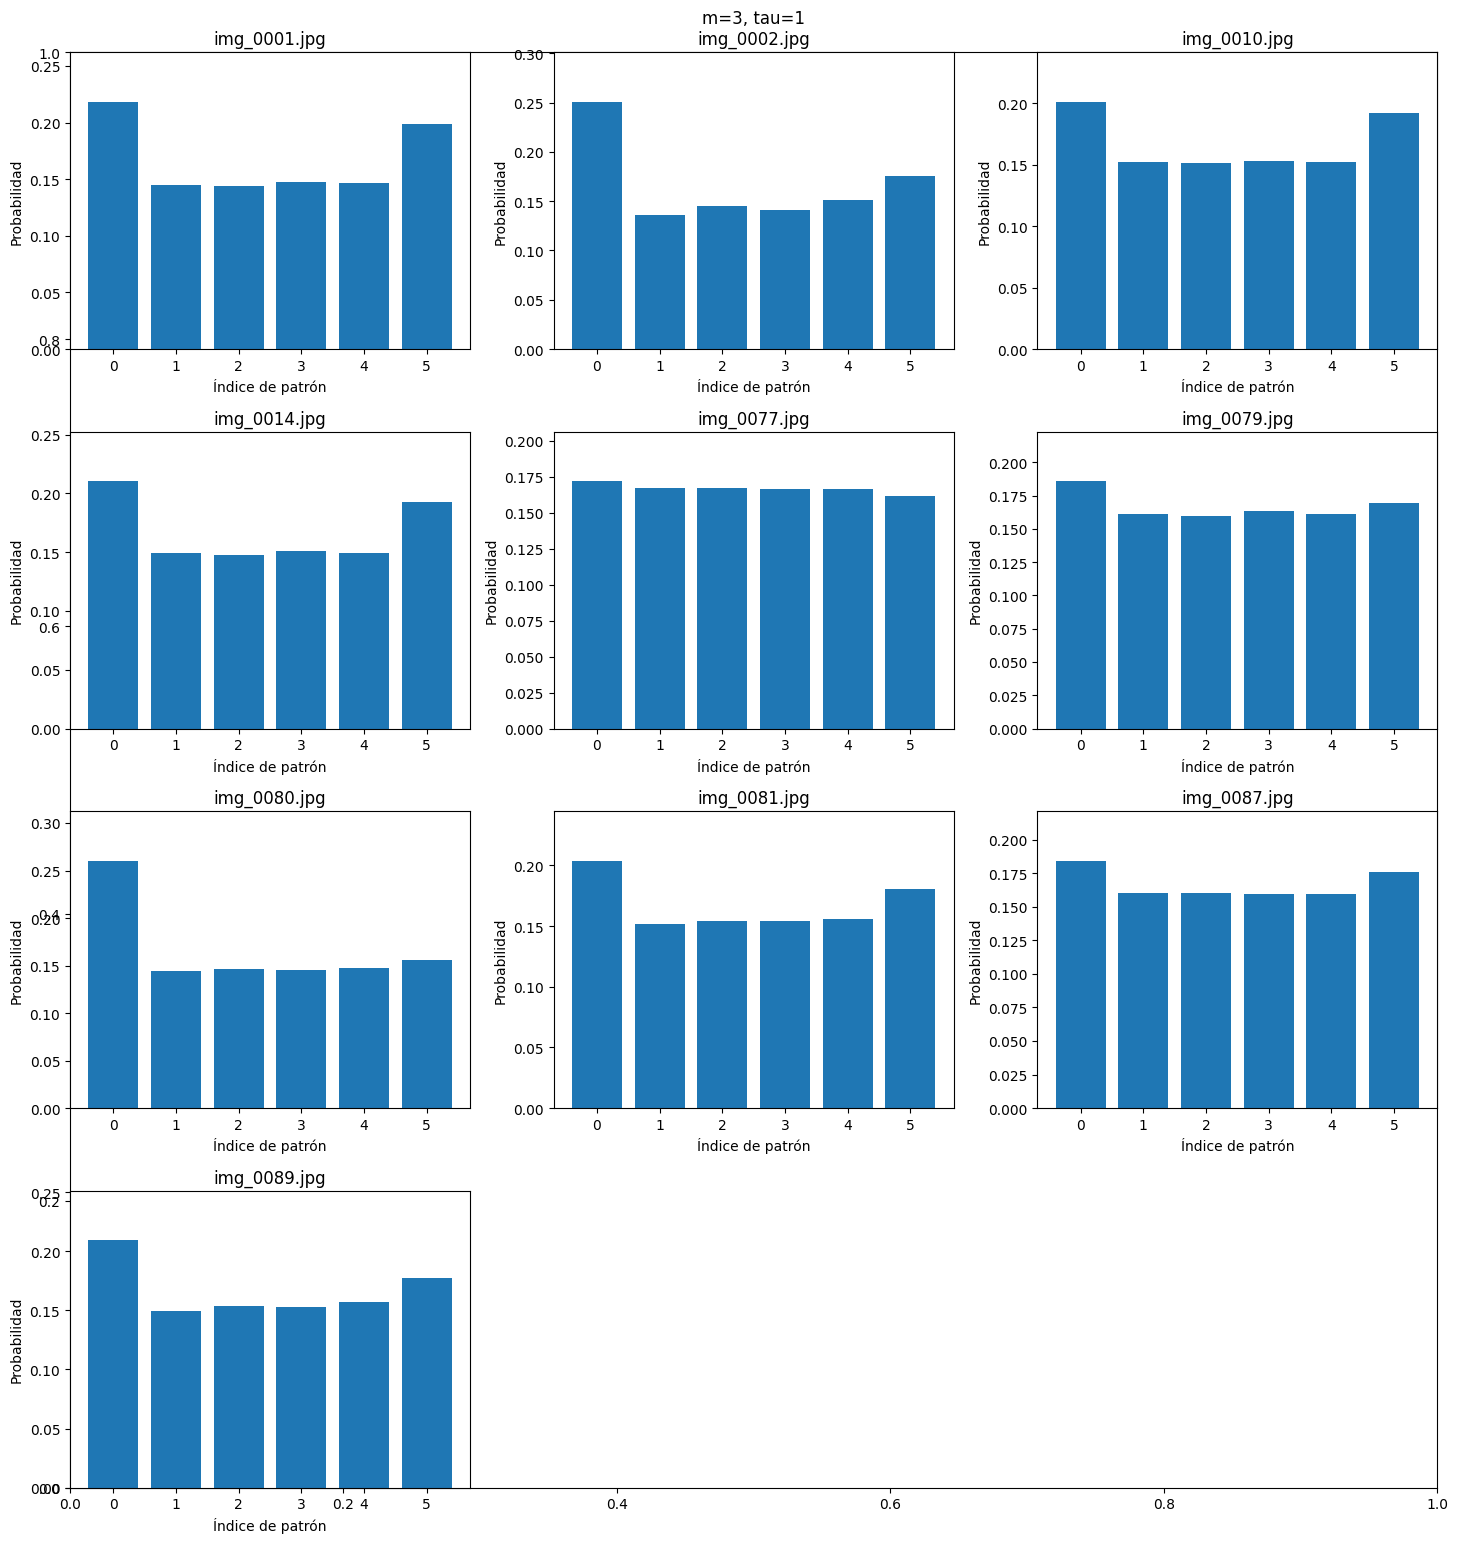

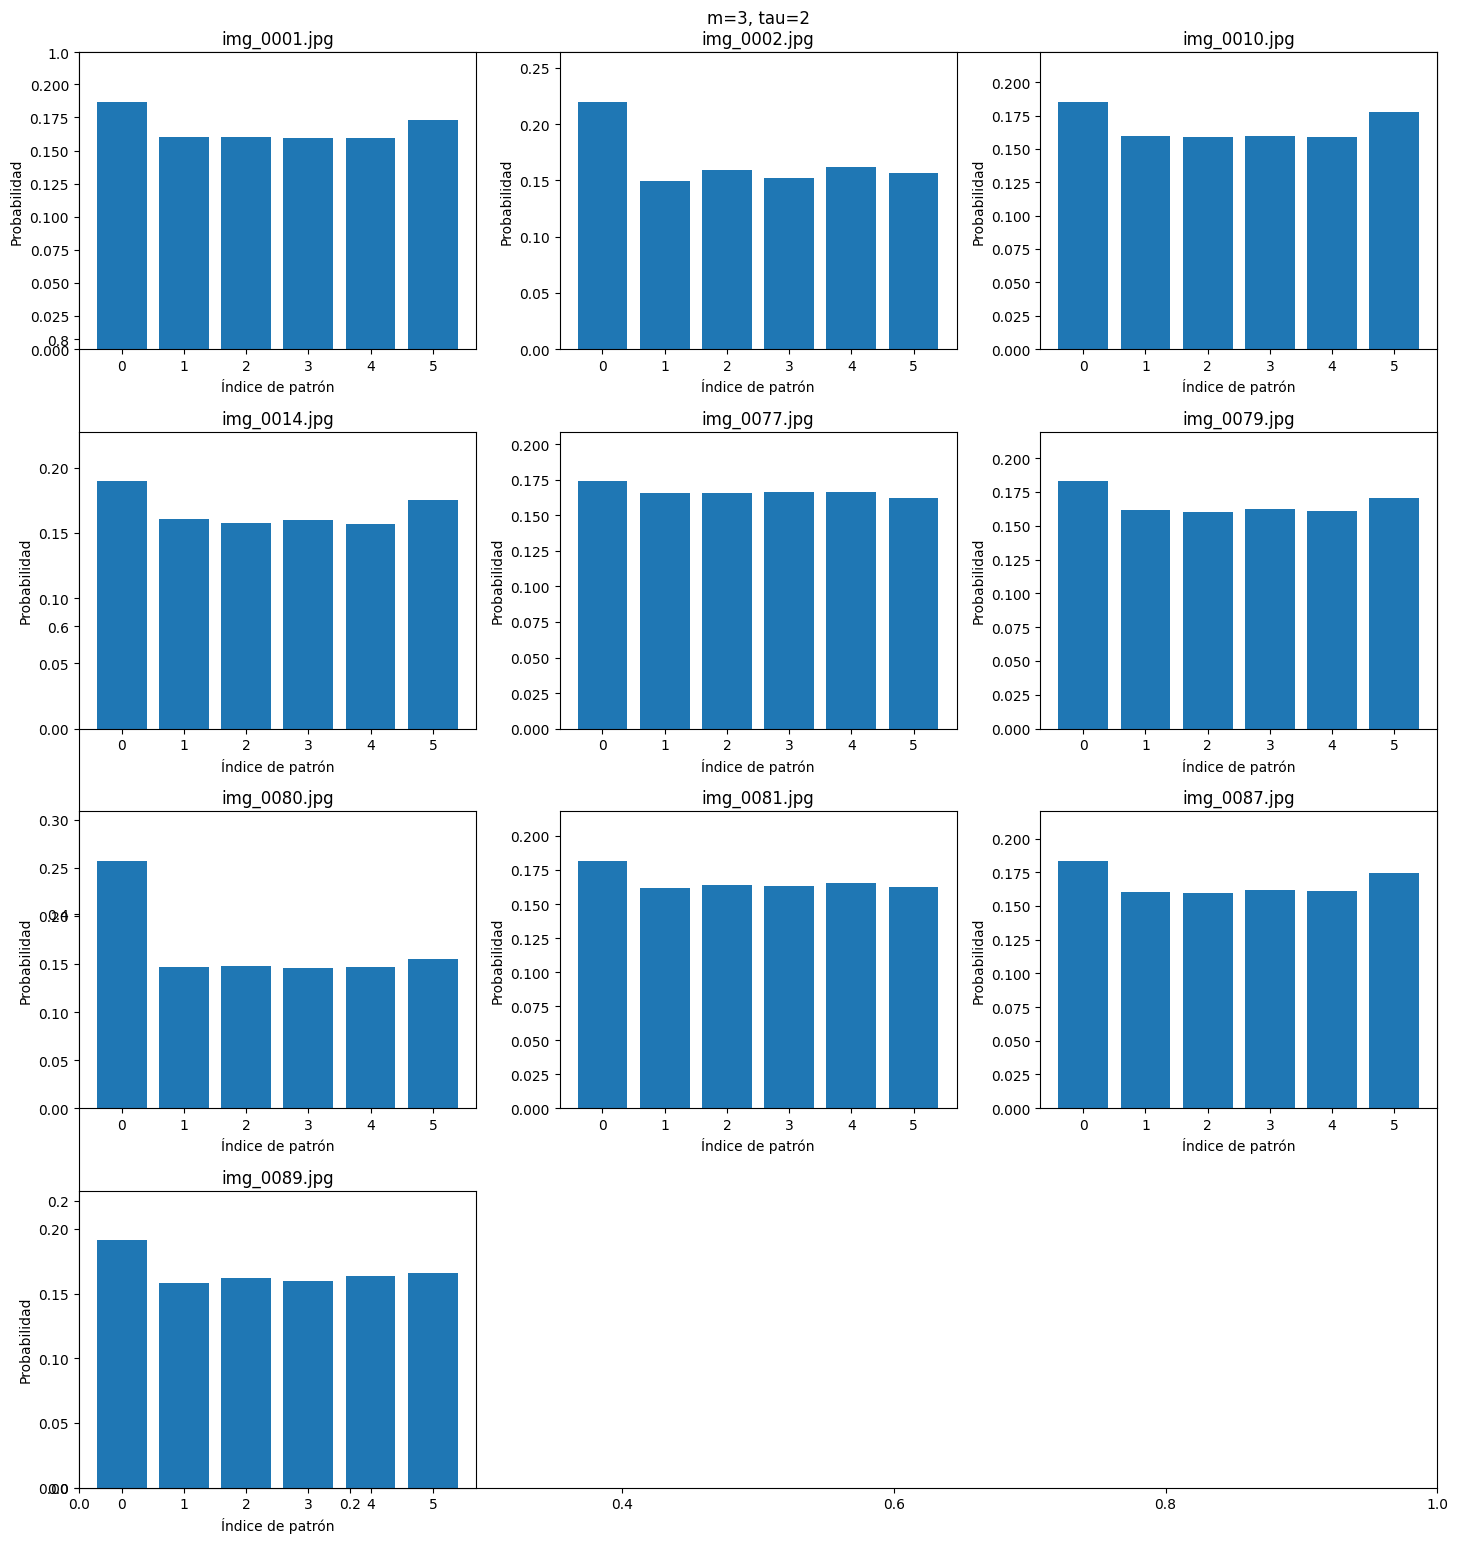

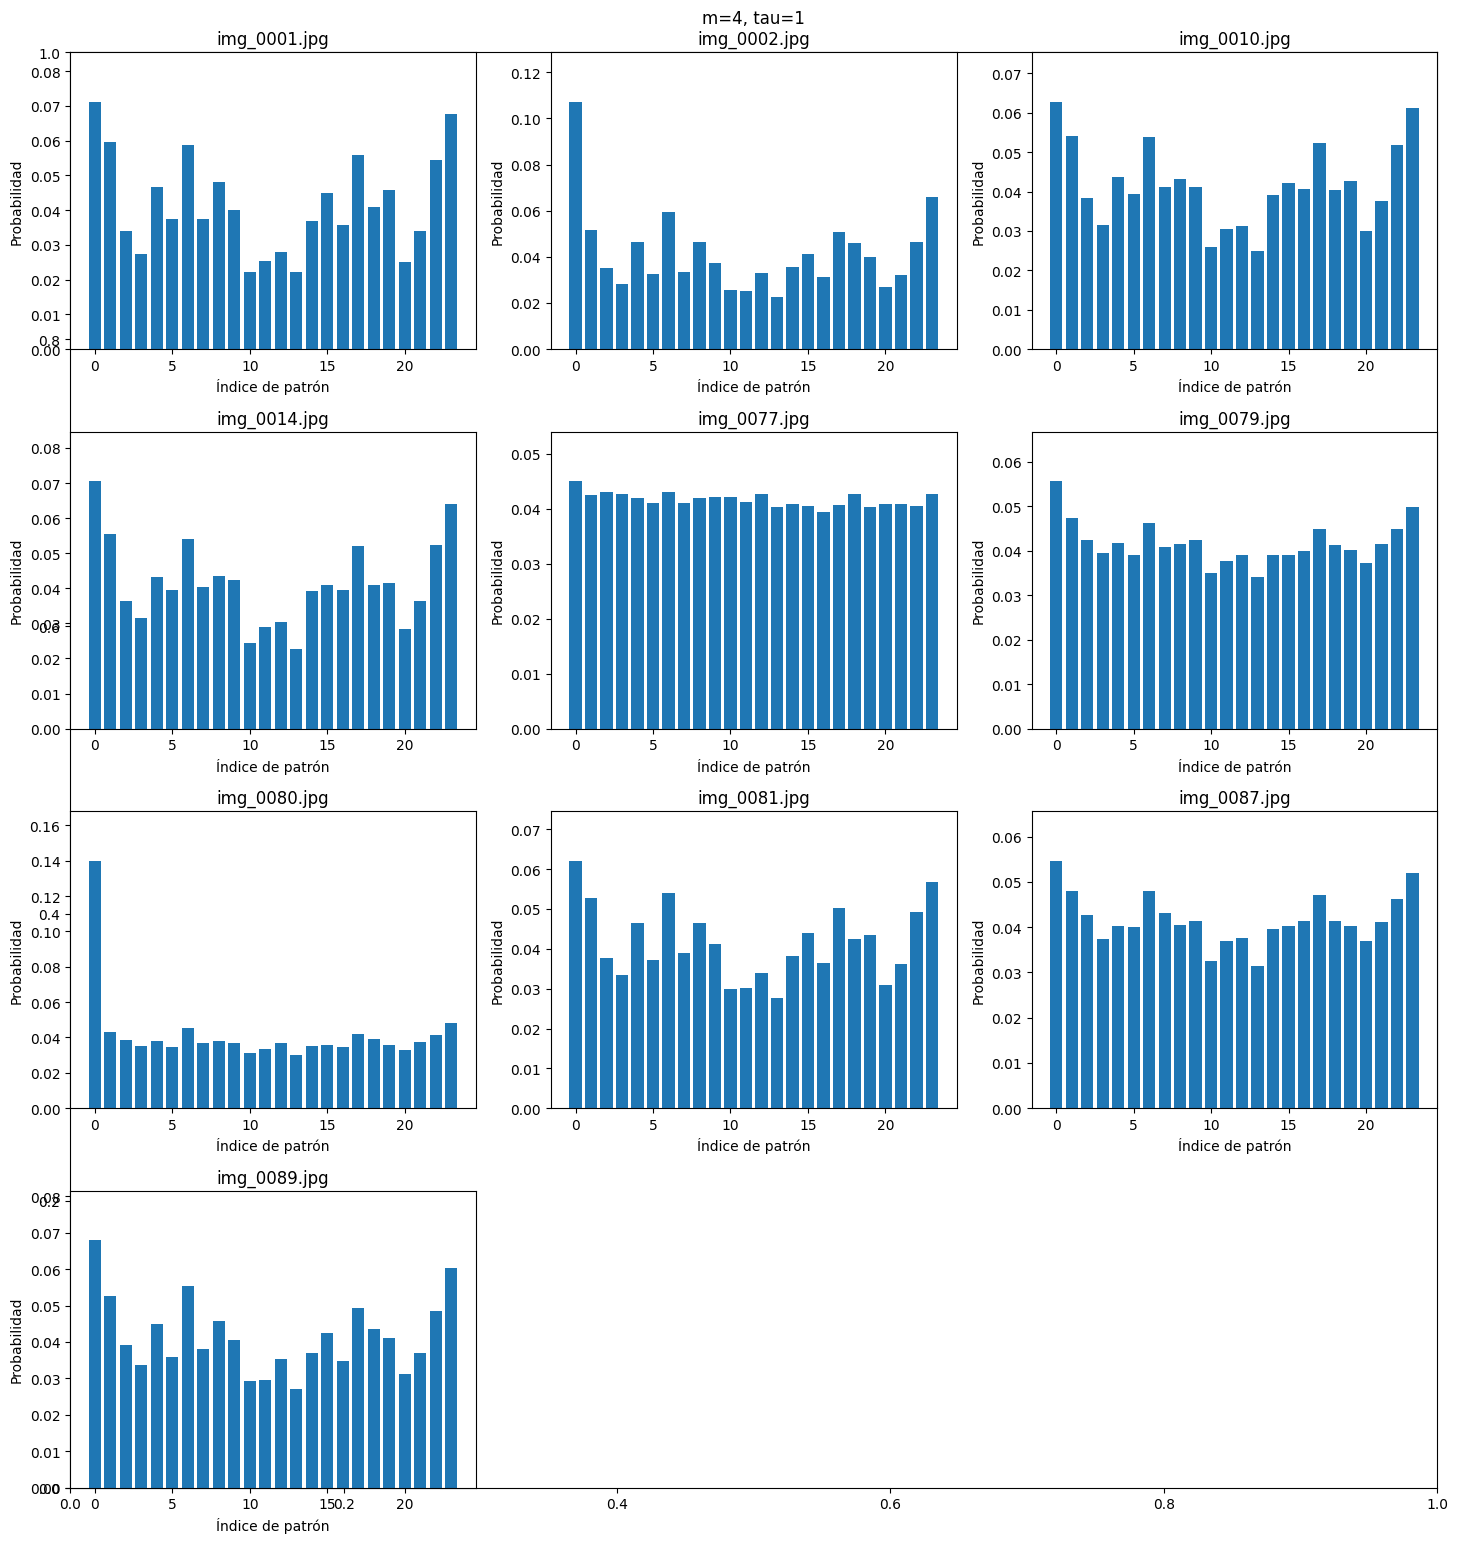

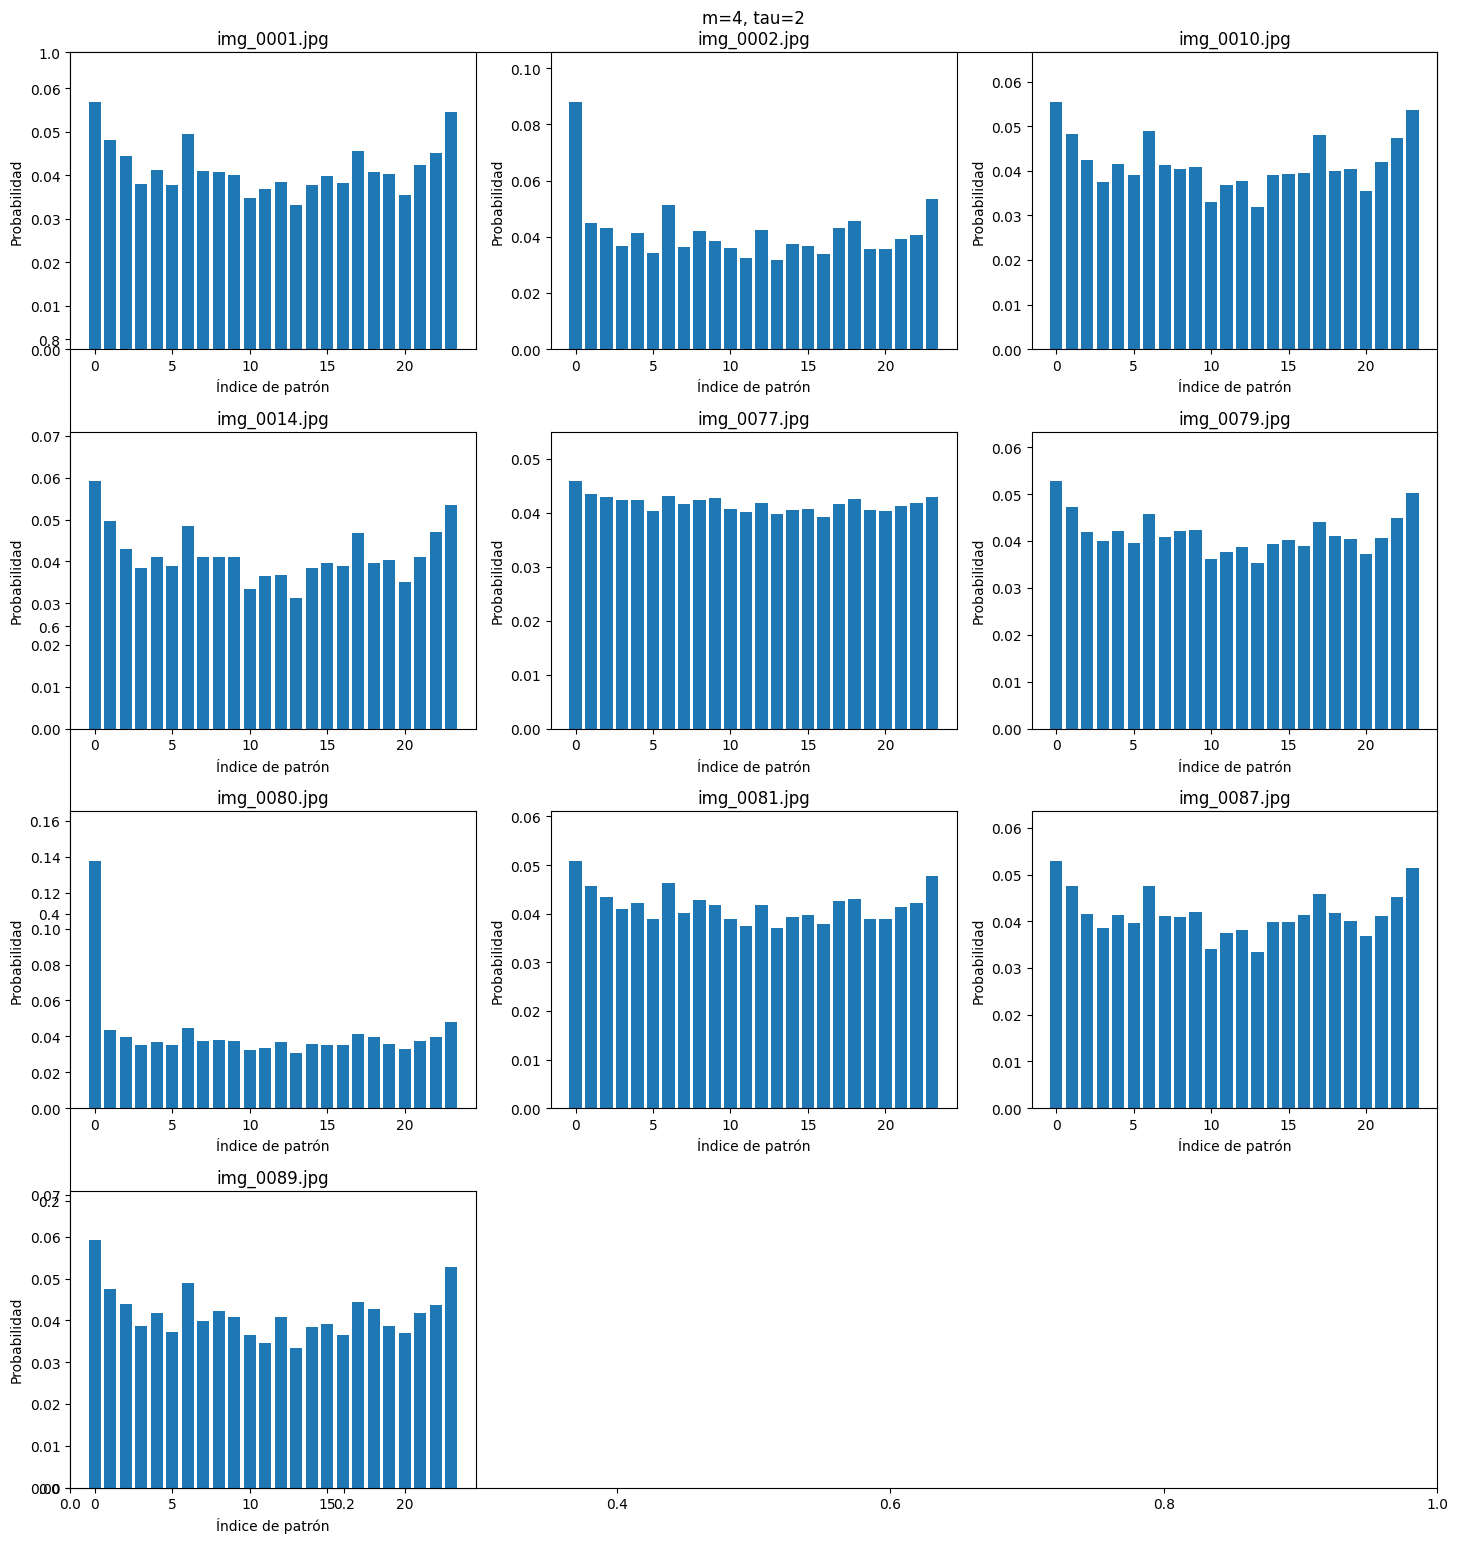

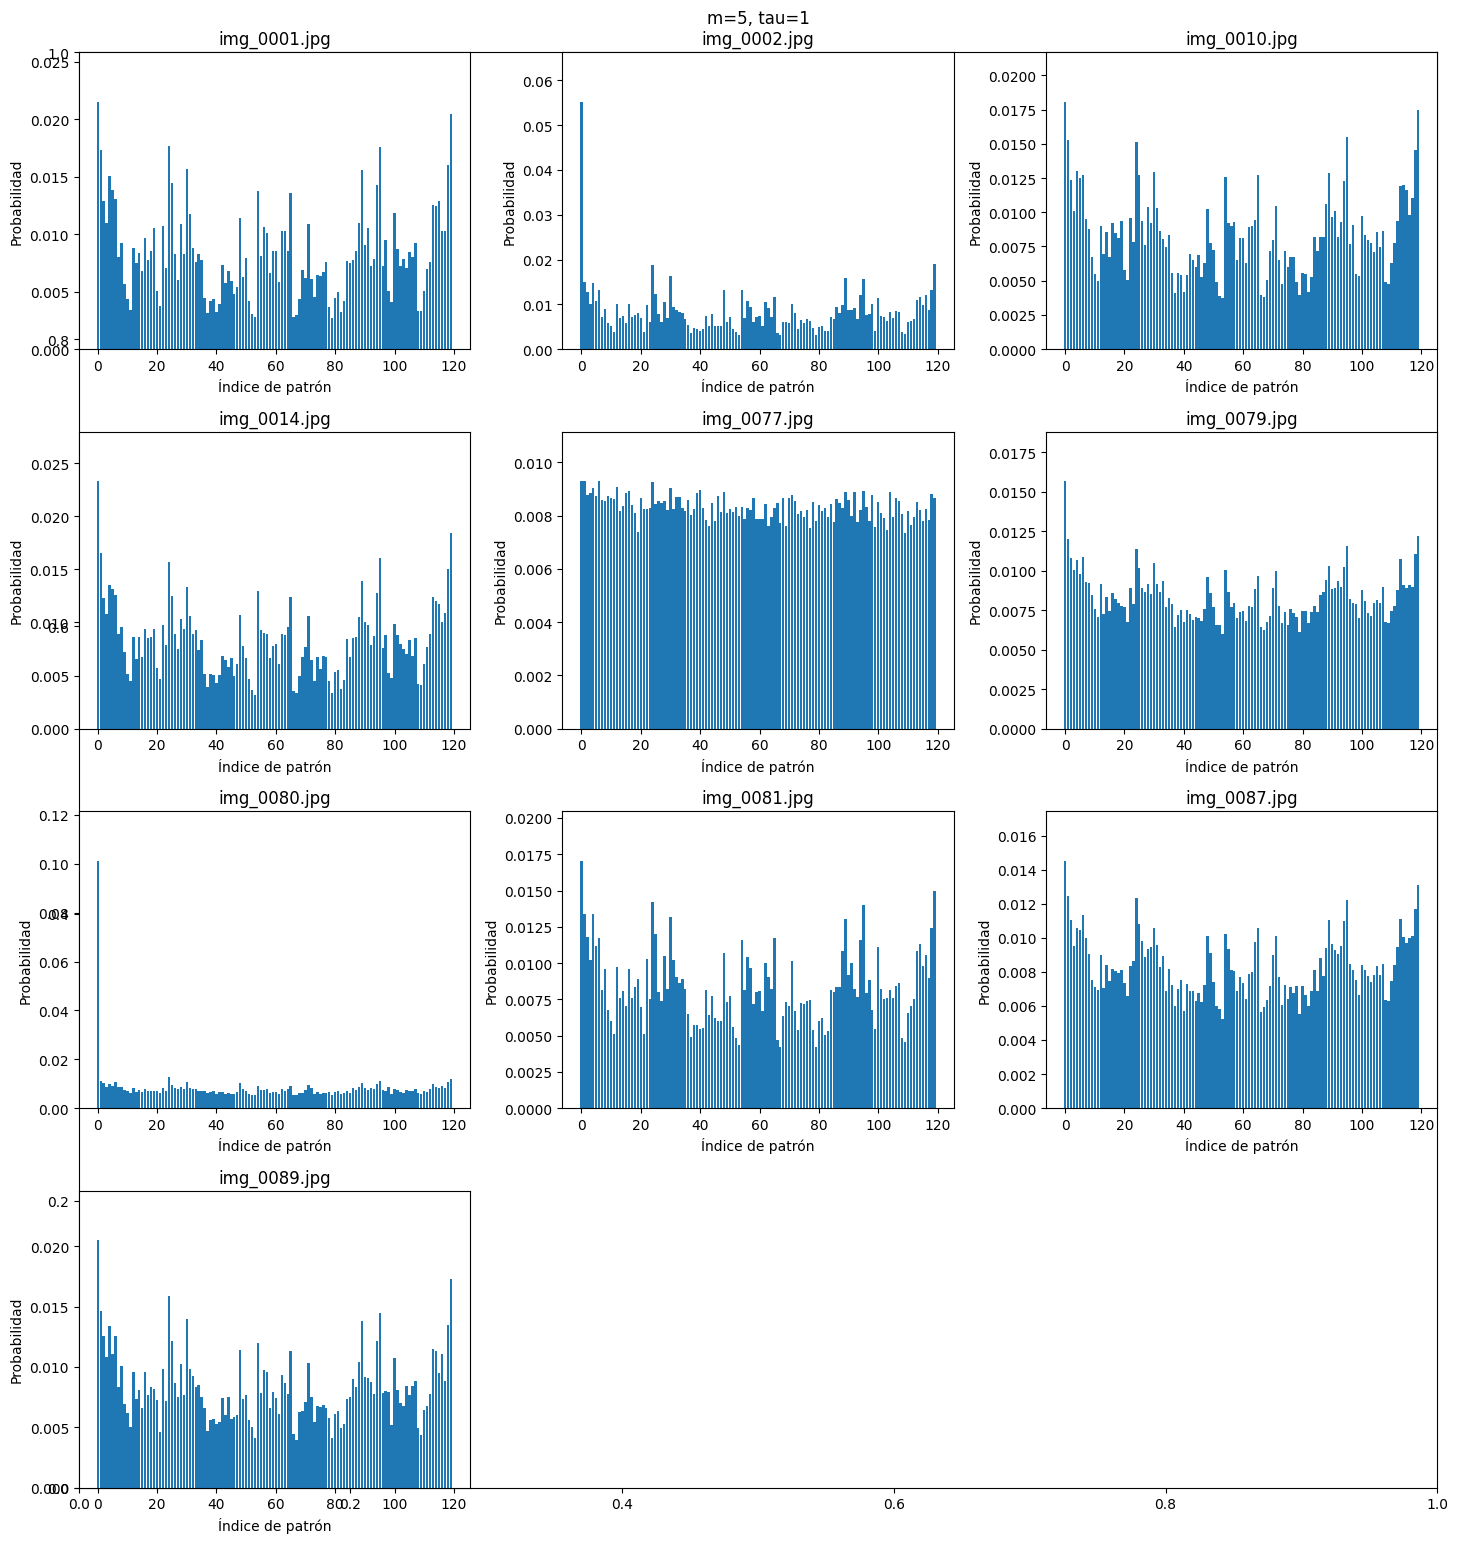

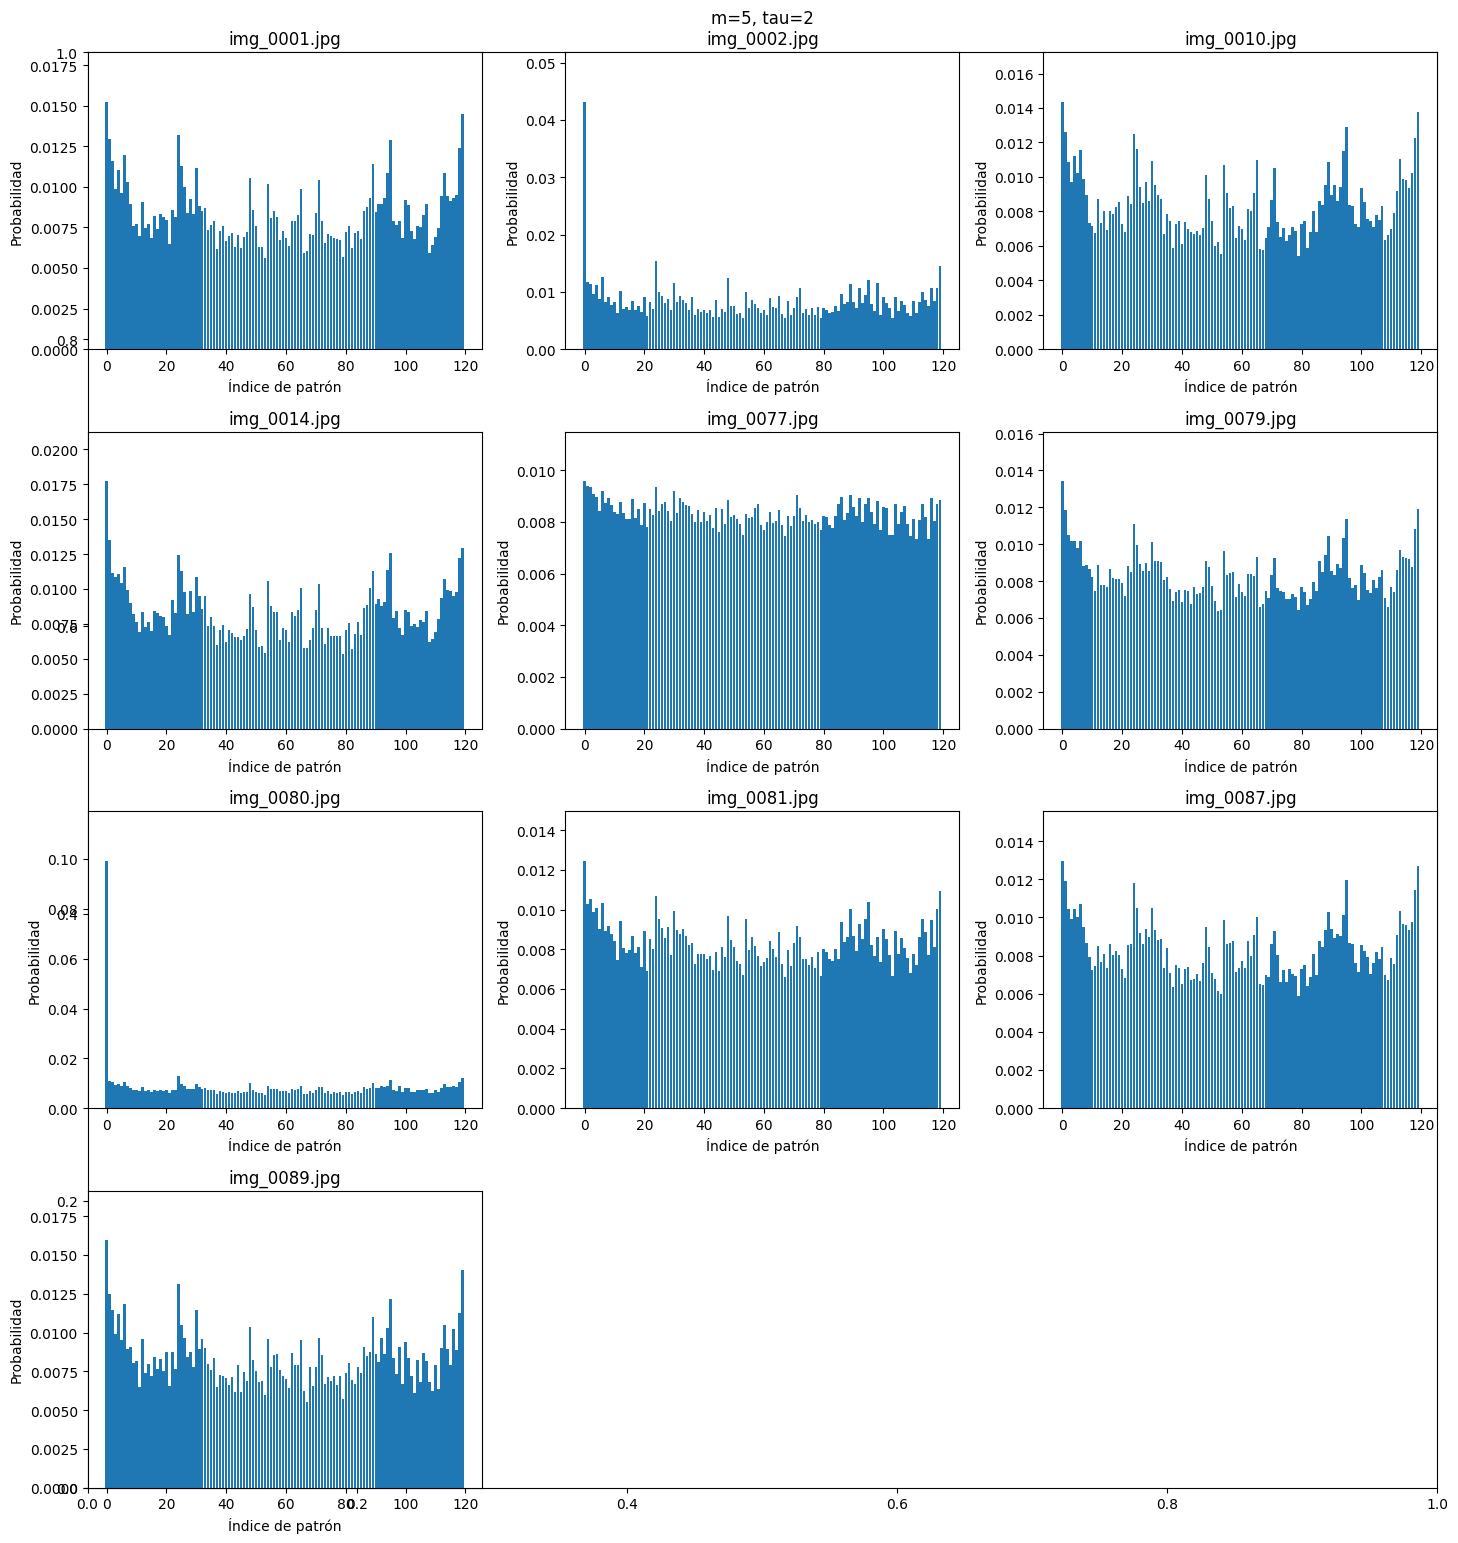

In [52]:
# Parámetros de embedding

m_values = [3, 4, 5]
tau_values = [1, 2]

for m, tau in product(m_values, tau_values):
    
    
    cols = df.columns
    ncols = 3
    nrows = int(np.ceil(len(cols) / ncols))
    
    plt.figure(figsize=(15, 4 * nrows))
    plt.title(f'm={m}, tau={tau}\n')
    for i, col in enumerate(cols, 1):
        x = df[col].values
    
        try:
            _, counts = utils.ordinal_patterns(x, emb_dim=m, emb_lag=tau)
            prob = counts / counts.sum()
        except ValueError:
            continue
    
        plt.subplot(nrows, ncols, i)
        plt.bar(np.arange(len(prob)), prob)
        plt.title(f"{col}")
        plt.xlabel("Índice de patrón")
        plt.ylabel("Probabilidad")
        plt.ylim(0, prob.max() * 1.2)
    
    plt.tight_layout()
    plt.show()


# Calculo entropias normalizadas

In [43]:
import divergence_entropy
import importlib
importlib.reload(divergence_entropy)
import pandas as pd

def entropy_complexity_full(df, m_values, tau_values, alpha=2.0, q=2.0):
    rows = []

    for col in df.columns:
        x = df[col].values

        for m, tau in product(m_values, tau_values):
            _, counts = utils.ordinal_patterns(x, emb_dim=m, emb_lag=tau)
            prob = counts / counts.sum()

            rows.append({
                "image": col,
                "m": m,
                "tau": tau,

                "H_shannon": divergence_entropy.shannon_entropy_normalized(prob),
                "C_shannon": divergence_entropy.complexity_shannon(prob),

                "H_renyi": divergence_entropy.renyi_entropy_normalized(prob, alpha),
                "C_renyi": divergence_entropy.complexity_renyi(prob, alpha),

                "H_tsallis": divergence_entropy.tsallis_entropy_normalized(prob, q),
                "C_tsallis": divergence_entropy.complexity_tsallis(prob, q),
            })

    return pd.DataFrame(rows)


In [44]:
entropy_complexity_df = entropy_complexity_full(df, m_values, tau_values)

In [61]:

ENTROPY_SPECS = {
    "shannon": {
        "H_col": "H_shannon",
        "C_col": "C_shannon",
        "H_func": divergence_entropy.shannon_entropy_normalized,
        "D_func": divergence_entropy.jensen_shannon_divergence_normalized,
        "label": "Shannon",
    },
    "renyi": {
        "H_col": "H_renyi",
        "C_col": "C_renyi",
        "H_func": lambda p: divergence_entropy.renyi_entropy_normalized(p, alpha=2.0),
        "D_func": lambda p: divergence_entropy.jensen_renyi_divergence_normalized(p, alpha=2.0),
        "label": r"Rényi ($\alpha=2$)",
    },
    "tsallis": {
        "H_col": "H_tsallis",
        "C_col": "C_tsallis",
        "H_func": lambda p: divergence_entropy.tsallis_entropy_normalized(p, q=2.0),
        "D_func": lambda p: divergence_entropy.jensen_tsallis_divergence_normalized(p, q=2.0),
        "label": r"Tsallis ($q=2$)",
    },
}


Cmin max: 0.17762207492473528
Cmax max: 0.14404053232203518
Cmin min: 4.185673079326132e-11
Cmax min: -0.0


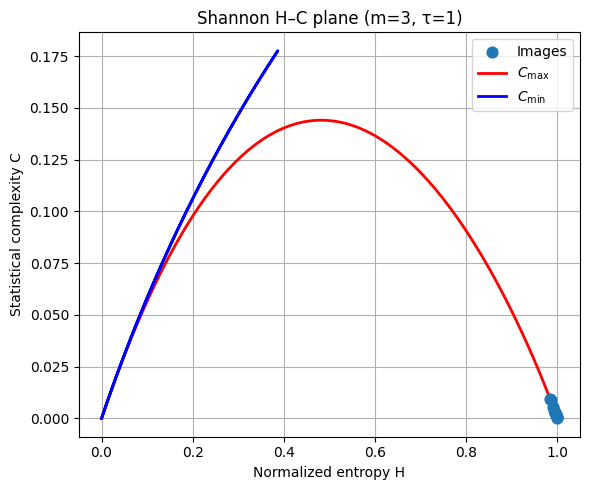

Cmin max: -5.314392980503804e-13
Cmax max: 0.0
Cmin min: -0.0779593983603869
Cmax min: -0.10618269942103736


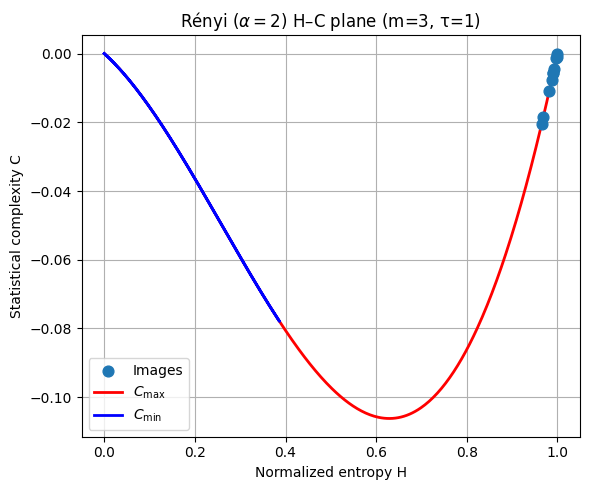

Cmin max: 0.21428569894234317
Cmax max: 0.21428551636807672
Cmin min: 8.229302953284261e-12
Cmax min: 0.0


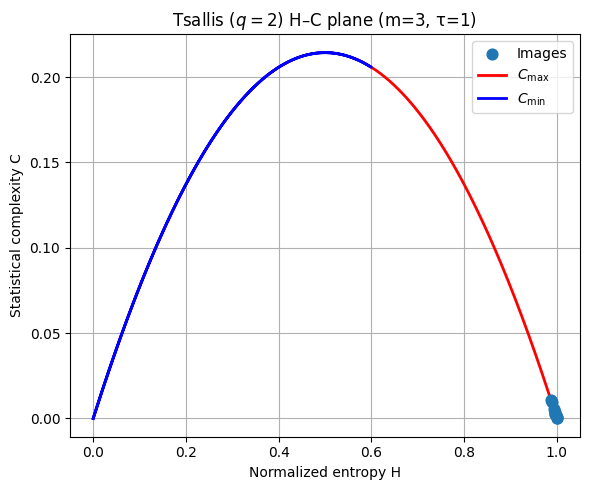

Cmin max: 0.17762207492473528
Cmax max: 0.14404053232203518
Cmin min: 4.185673079326132e-11
Cmax min: -0.0


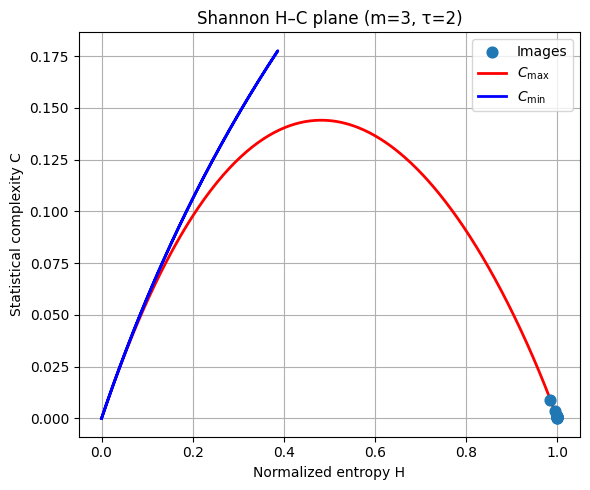

Cmin max: -5.314392980503804e-13
Cmax max: 0.0
Cmin min: -0.0779593983603869
Cmax min: -0.10618269942103736


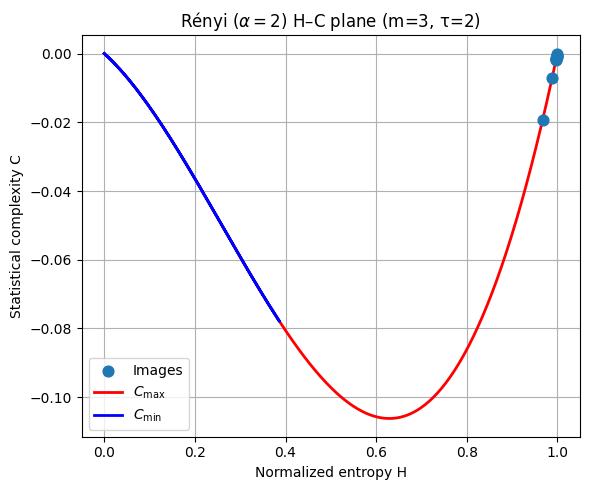

Cmin max: 0.21428569894234317
Cmax max: 0.21428551636807672
Cmin min: 8.229302953284261e-12
Cmax min: 0.0


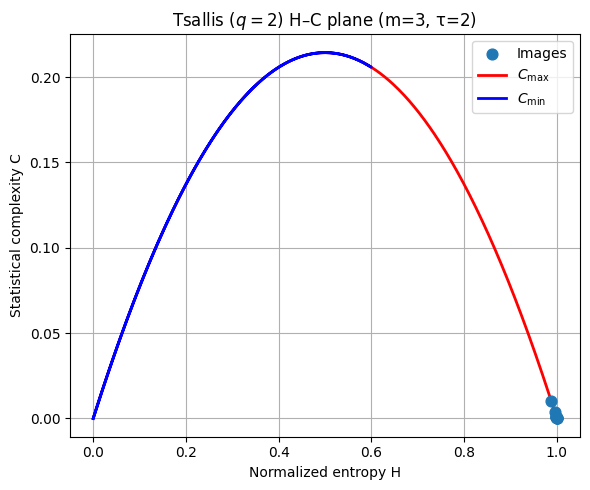

Cmin max: 0.17188210517767635
Cmax max: 0.18830813037593022
Cmin min: 1.7318628260694167e-10
Cmax min: -0.0


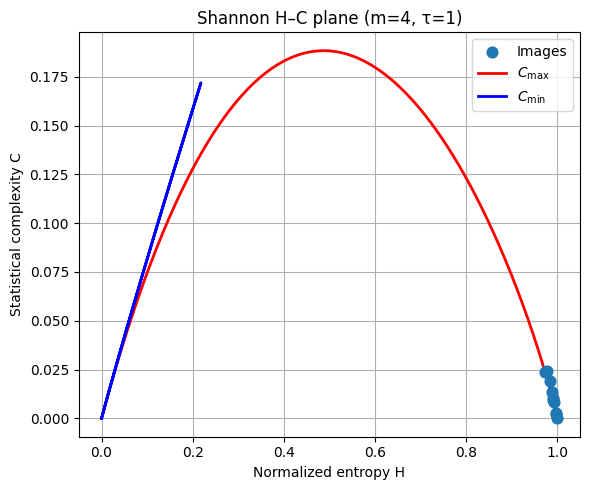

Cmin max: 0.011851535838215235
Cmax max: 0.011851507884524257
Cmin min: 2.368715001858168e-12
Cmax min: -0.05323853588625526


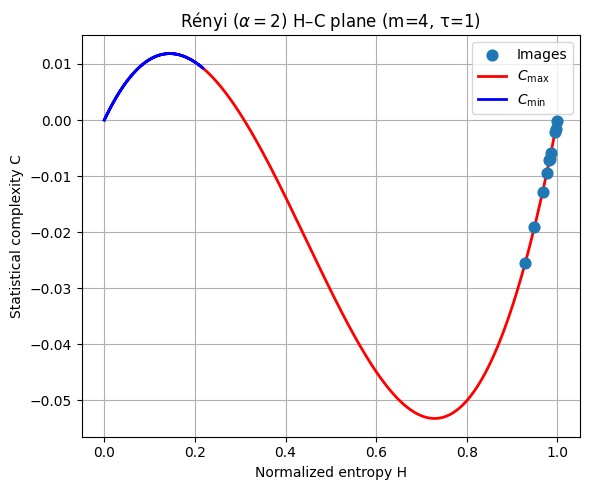

Cmin max: 0.23999994599130178
Cmax max: 0.2399997783322462
Cmin min: 4.407688127324561e-11
Cmax min: 0.0


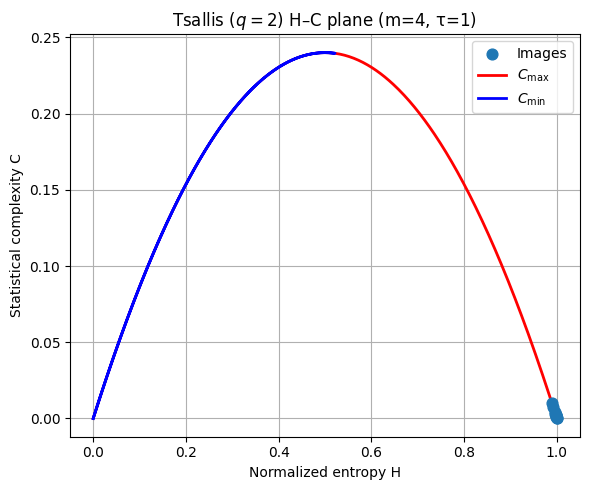

Cmin max: 0.17188210517767635
Cmax max: 0.18830813037593022
Cmin min: 1.7318628260694167e-10
Cmax min: -0.0


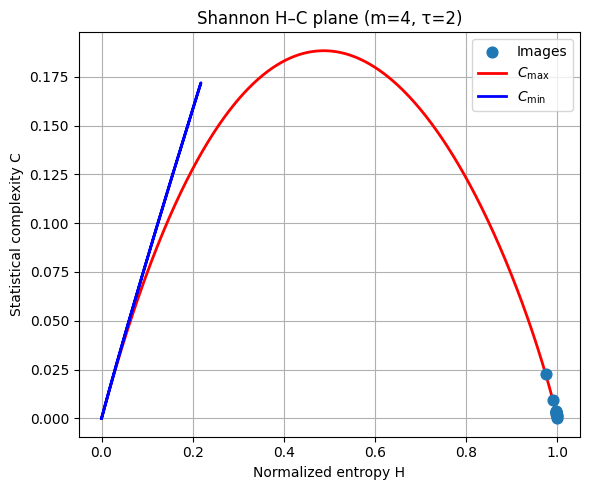

Cmin max: 0.011851535838215235
Cmax max: 0.011851507884524257
Cmin min: 2.368715001858168e-12
Cmax min: -0.05323853588625526


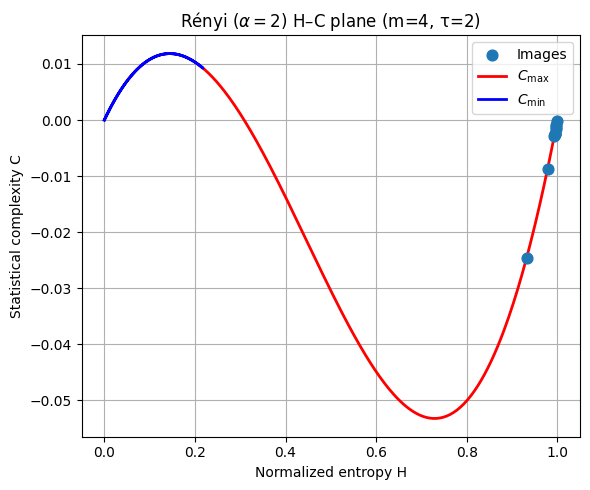

Cmin max: 0.23999994599130178
Cmax max: 0.2399997783322462
Cmin min: 4.407688127324561e-11
Cmax min: 0.0


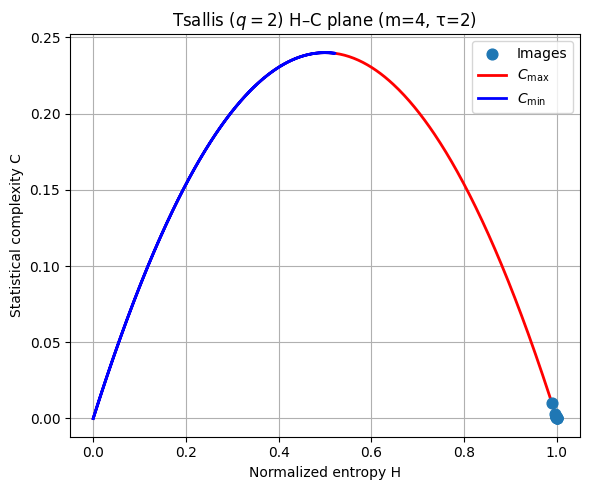

Cmin max: 0.1359004593120857
Cmax max: 0.1997979926983423
Cmin min: 6.811167433166483e-10
Cmax min: -0.0


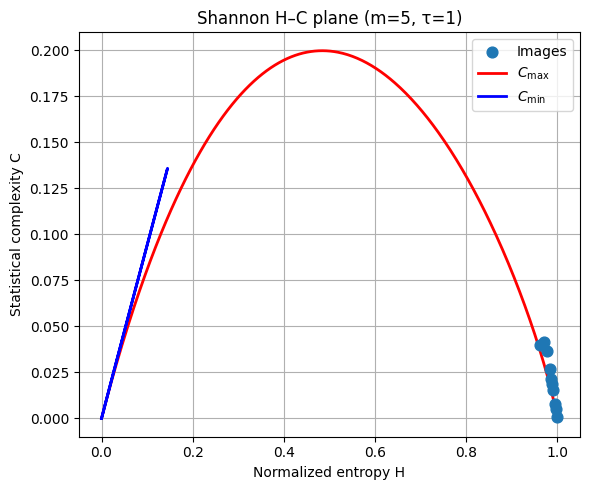

Cmin max: 0.030062458363067306
Cmax max: 0.03574666707191013
Cmin min: 1.4886842239581477e-11
Cmax min: -0.033087591078784916


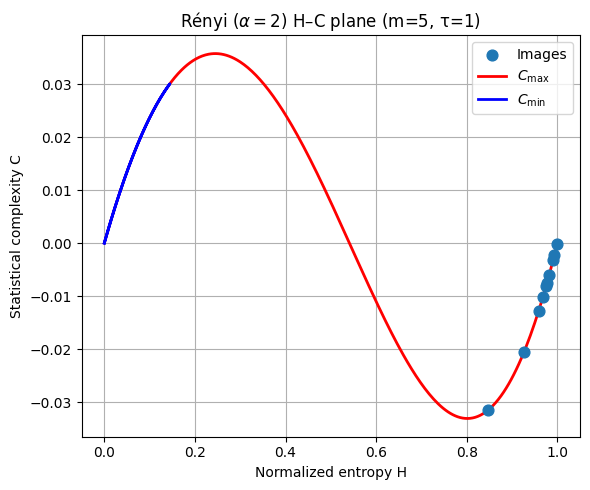

Cmin max: 0.24793386647758944
Cmax max: 0.24793365530190725
Cmin min: 2.360187189232678e-10
Cmax min: 0.0


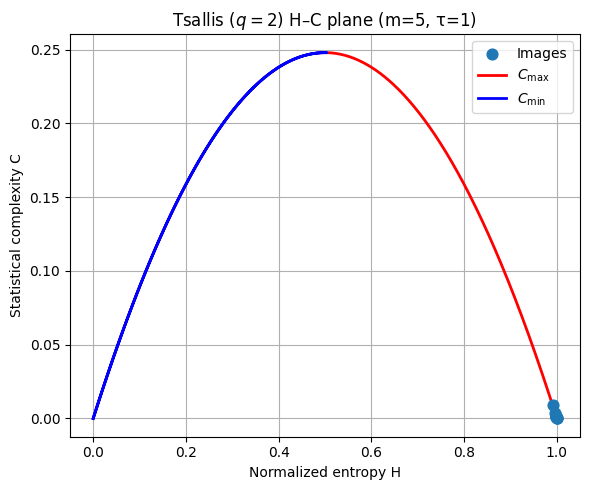

Cmin max: 0.1359004593120857
Cmax max: 0.1997979926983423
Cmin min: 6.811167433166483e-10
Cmax min: -0.0


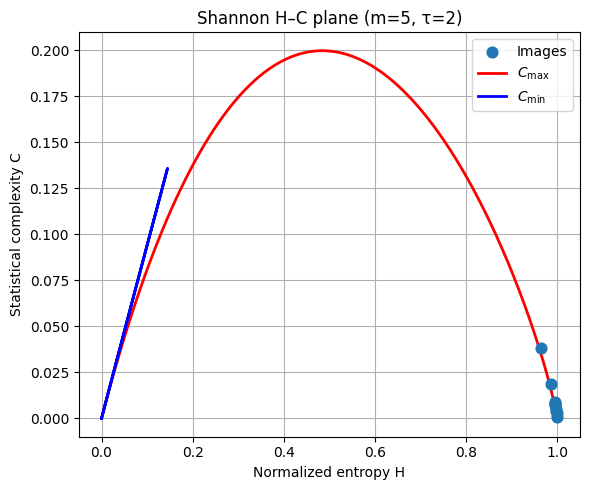

Cmin max: 0.030062458363067306
Cmax max: 0.03574666707191013
Cmin min: 1.4886842239581477e-11
Cmax min: -0.033087591078784916


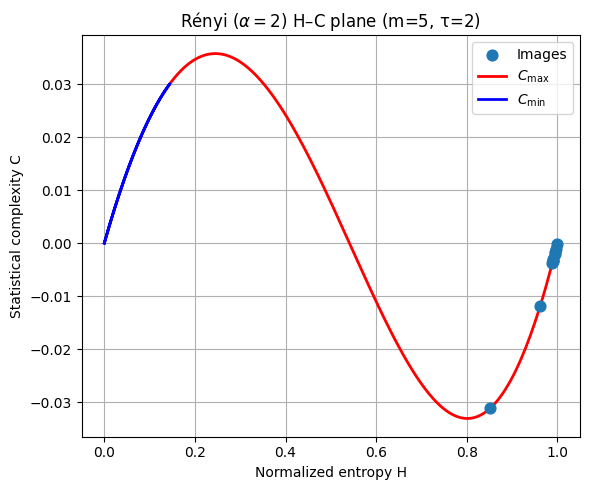

Cmin max: 0.24793386647758944
Cmax max: 0.24793365530190725
Cmin min: 2.360187189232678e-10
Cmax min: 0.0


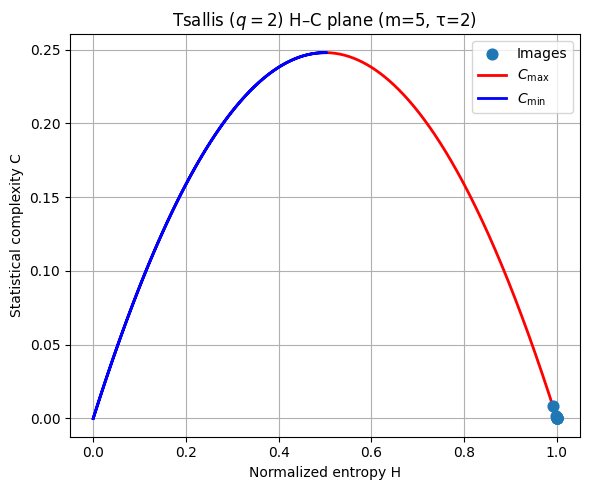

In [63]:
from itertools import product
importlib.reload(utils)

for m, tau in product(m_values, tau_values):
    subset = entropy_complexity_df[
        (entropy_complexity_df.m == m) &
        (entropy_complexity_df.tau == tau)
    ]

    for spec in ENTROPY_SPECS.values():
        utils.plot_entropy_complexity_planes(
            subset_df=subset,
            m=m,
            tau=tau,
            spec=spec
        )
